In [1]:
# Imports
import numpy
import pandas
import sklearn
import sklearn.dummy
import sklearn.ensemble
import sklearn.grid_search
import sklearn.linear_model
import sklearn.metrics
import sklearn.pipeline

In [2]:
# Matplotlib setup
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
seaborn.set()

In [3]:
# Load justice-centered SCDB data
scdb_data = pandas.read_csv("data/SCDB_2013_01_justiceCentered_Citation.csv")

## Disposition outcoming coding

  In the section below, we transform the SCDB vote and caseDisposition variables into an outcome variable indicating whether the case overall and each Justice has affirmed or reverse.
  
  * vote: [http://scdb.wustl.edu/documentation.php?var=vote#norms](http://scdb.wustl.edu/documentation.php?var=vote#norms)
  * caseDisposition: [http://scdb.wustl.edu/documentation.php?var=caseDisposition#norms](http://scdb.wustl.edu/documentation.php?var=caseDisposition#norms)

In [4]:
"""
Setup the outcome map.

Rows correspond to vote types.  Columns correspond to disposition types.

Element values correspond to:
 * -1: no precedential issued opinion or uncodable, i.e., DIGs
 * 0: affirm, i.e., no change in precedent
 * 1: reverse, i.e., change in precent
"""
outcome_map = pandas.DataFrame([[-1, 0, 1, 1, 1, 0, 1, -1, -1, -1, -1],
               [-1, 1, 0, 0, 0, 1, 0, -1, -1, -1, -1],
               [-1, 0, 1, 1, 1, 0, 1, -1, -1, -1, -1],
               [-1, 0, 1, 1, 1, 0, 1, -1, -1, -1, -1],
               [-1, 0, 1, 1, 1, 0, 1, -1, -1, -1, -1],
               [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
               [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
               [-1, 0, 0, 0, -1, 0, -1, -1, -1, -1, -1]])
outcome_map.columns = range(1, 12)
outcome_map.index = range(1, 9)

def get_outcome(vote, disposition):
    """
    Return the outcome code.
    """
    if pandas.isnull(vote) or pandas.isnull(disposition):
        return -1
    
    return outcome_map.loc[int(vote), int(disposition)]

In [5]:
# Map the case-level disposition outcome 
scdb_data.loc[:, "case_outcome_disposition"] = outcome_map.loc[1, scdb_data.loc[:, "caseDisposition"]].values
scdb_data.loc[:, "lc_case_outcome_disposition"] = outcome_map.loc[1, scdb_data.loc[:, "lcDisposition"]].values

# Map the justice-level disposition outcome
scdb_data.loc[:, "justice_outcome_disposition"] = scdb_data.loc[:, ("vote", "caseDisposition")] \
    .apply(lambda row: get_outcome(row["vote"], row["caseDisposition"]), axis=1)

## Running a simulation

  In the section below, we define methods that handle the execution and analysis of simulations.  Simulations are based around the following concepts:
  
  * __prediction methods__: prediction methods take historical data and determine, for each term-justice,  what prediction to make.
  * __preprocessing methods__: methods to clean and reshape feature data on input

In [6]:
# Court to circuit mapping, which maps from SCDB codebook to the actual Circuit number
# http://scdb.wustl.edu/documentation.php?var=caseOrigin
# http://scdb.wustl.edu/documentation.php?var=caseSource
court_circuit_map = {1: 13,
                     2: 13, 3: 13, 4: 14, 5: 14, 6: 13, 7: 13, 8: 13,
                     9: 22, 10: 99, 12: 9, 13: 99, 14: 13, 15: 99, 16: 99,
                     17: 99, 18: 99, 19: 0, 20: 22, 21: 1, 22: 2, 23: 3,
                     24: 4, 25: 5, 26: 6, 27: 7, 28: 8, 29: 9, 30: 10,
                     31: 11, 32: 12, 41: 11, 42: 11, 43: 11, 44: 9, 45: 9,
                     46: 8, 47: 8, 48: 9, 49: 9, 50: 9, 51: 9, 52: 10, 53: 2,
                     54: 3, 55: 12, 56: 11, 57: 11, 58: 11, 59: 11, 60: 11,
                     61: 11, 62: 9, 63: 9, 64: 9, 65: 7, 66: 7, 67: 7, 68: 7,
                     69: 7, 70: 8, 71: 8, 72: 10, 73: 6, 74: 6, 75: 5, 76: 5,
                     77: 5, 78: 1, 79: 4, 80: 1, 81: 6, 82: 6, 83: 8, 84: 5,
                     85: 5, 86: 8, 87: 8, 88: 9, 89: 8, 90: 9, 91: 1, 92: 3,
                     93: 10, 94: 2, 95: 2, 96: 2, 97: 2, 98: 4, 99: 4, 100: 4,
                     101: 8, 102: 9, 103: 6, 104: 6, 105: 10, 106: 10, 107: 10,
                     108: 9, 109: 3, 110: 3, 111: 3, 112: 1, 113: 1, 114: 4,
                     115: 8, 116: 6, 117: 6, 118: 6, 119: 5, 120: 5, 121: 5,
                     122: 5, 123: 10, 124: 2, 125: 3, 126: 4, 127: 4, 128: 9,
                     129: 9, 130: 4, 131: 4, 132: 7, 133: 7, 134: 10, 150: 5,
                     151: 9, 152: 4, 153: 7, 155: 4, 160: 4, 162: 11, 163: 5,
                     164: 11, 165: 7, 166: 7, 167: 8, 168: 6, 169: 5, 170: 8,
                     171: 3, 172: 3, 173: 2, 174: 4, 175: 6, 176: 3, 177: 3,
                     178: 5, 179: 4, 180: 4, 181: 7, 182: 6, 183: 3, 184: 9,
                     185: 11, 186: 8, 187: 5, 300: 0, 301: 0, 302: 0, 400: 99,
                     401: 99, 402: 99, 403: 11, 404: 8, 405: 9, 406: 2, 407: 3,
                     408: 11, 409: 11, 410: 7, 411: 7, 412: 8, 413: 10, 414: 6,
                     415: 5, 416: 1, 417: 4, 418: 1, 419: 6, 420: 8,
                     421: 5, 422: 8, 423: 9, 424: 1, 425: 3, 426: 2,
                     427: 4, 428: 6, 429: 9, 430: 3, 431: 1, 432: 4, 433: 6,
                     434: 5, 435: 2, 436: 4, 437: 4, 438: 7,
                     439: 10, 440: 12, 441: 8, 442: 10, 443: 9}


def map_circuit(value):
    try:
        return court_circuit_map[value]
    except:
        return 0

# Get lists of classes for categorical vars
# Issue area
issue_area_codes = [0]
issue_area_codes.extend(sorted(scdb_data['issueArea'].fillna(0).apply(int).unique().tolist()))

# Issue
issue_codes = [0]
issue_codes.extend(sorted(scdb_data['issue'].fillna(0).apply(int).unique().tolist()))

# Courts
court_circuit_codes = [0]
court_circuit_codes.extend(sorted(list(set(court_circuit_map.values()))))

# Admin action
admin_action_codes = [0]
admin_action_codes.extend(sorted(scdb_data['adminAction'].fillna(0).apply(int).unique().tolist()))

# Law types
law_type_codes = [0]
law_type_codes.extend(sorted(scdb_data['lawType'].fillna(0).apply(int).unique().tolist()))

# Law supp types
law_supp_codes = [0]
law_supp_codes.extend(sorted(scdb_data['lawSupp'].fillna(0).apply(int).unique().tolist()))

# Cert reason
cert_reason_codes = [0]
cert_reason_codes.extend(sorted(scdb_data['certReason'].fillna(0).apply(int).unique().tolist()))

# Jurisdiction
jurisdiction_codes = [0]
jurisdiction_codes.extend(sorted(scdb_data['jurisdiction'].fillna(0).apply(int).unique().tolist()))

# LC Disagreement
lc_disagreement_codes = [0]
lc_disagreement_codes.extend(sorted(scdb_data['lcDisagreement'].fillna(0).apply(int).unique().tolist()))

# Justice codes
justice_codes = [0]
justice_codes.extend(sorted(scdb_data['justice'].fillna(0).apply(int).unique().tolist()))

# Parties
party_codes = [0]
party_codes.extend(sorted(scdb_data['petitioner'].fillna(0).apply(int).unique()))
party_codes.extend(sorted(scdb_data['respondent'].fillna(0).apply(int).unique()))
party_codes = sorted(list(set(party_codes)))

# LC outcome
lc_case_outcome_codes = [0]
lc_case_outcome_codes.extend(sorted(scdb_data['lc_case_outcome_disposition'].fillna(0).apply(int).unique().tolist()))


In [7]:
def preprocess_data(data):
    """
    Process SCDB data frame into features.
    """
    # Encode admin action
    admin_action_encoded = sklearn.preprocessing.label_binarize(data['adminAction'].fillna(0).apply(int),
                                                      admin_action_codes)
    # Encode issue area
    issue_area_encoded = sklearn.preprocessing.label_binarize(data['issueArea'].fillna(0).apply(int),
                                                      issue_area_codes)

    issue_encoded = sklearn.preprocessing.label_binarize(data['issue'].fillna(0).apply(int),
                                                      issue_codes)
    # Encode law type, cert reason, and jurisdiction
    law_type_encoded = sklearn.preprocessing.label_binarize(data['lawType'].fillna(0).apply(int),
                                                      law_type_codes)

    law_supp_encoded = sklearn.preprocessing.label_binarize(data['lawSupp'].fillna(0).apply(int),
                                                      law_type_codes)


    cert_reason_encoded = sklearn.preprocessing.label_binarize(data['certReason'].fillna(0).apply(int),
                                                      cert_reason_codes)

    jurisdiction_encoded = sklearn.preprocessing.label_binarize(data['jurisdiction'].fillna(0).apply(int),
                                                      jurisdiction_codes)
    # Encode courts
    data.loc[:, 'case_source_map'] = data['caseSource'].apply(map_circuit).apply(int)
    data.loc[:, 'case_origin_map'] = data['caseOrigin'].apply(map_circuit).apply(int)

    case_source_encoded = sklearn.preprocessing.label_binarize(data['case_source_map'].fillna(0).apply(int),
                                                      court_circuit_codes)
    case_origin_encoded = sklearn.preprocessing.label_binarize(data['case_origin_map'].fillna(0).apply(int),
                                                      court_circuit_codes)

    # Encode parties
    petitioner_encoded = sklearn.preprocessing.label_binarize(data['petitioner'].fillna(0).apply(int),
                                                              party_codes)
    respondent_encoded = sklearn.preprocessing.label_binarize(data['respondent'].fillna(0).apply(int),
                                                              party_codes)

    # Justice
    justice_encoded = sklearn.preprocessing.label_binarize(data['justice'].fillna(0).apply(int),
                                                              justice_codes)
    
    lc_outcome_encoded = sklearn.preprocessing.label_binarize(data['lc_case_outcome_disposition'].fillna(0).apply(int),
                                                  lc_case_outcome_codes)
    
    return numpy.hstack((justice_encoded, admin_action_encoded, issue_area_encoded, issue_encoded,
                         law_type_encoded, law_supp_encoded, cert_reason_encoded, jurisdiction_encoded,
                         case_source_encoded, case_origin_encoded, petitioner_encoded, respondent_encoded,
                         lc_outcome_encoded))

# Test shape
scdb_feature_data = preprocess_data(scdb_data)
print(scdb_feature_data.shape)


(76037, 1057)


In [40]:
search_parameters = {
    'classify__max_leaf_nodes': [512],
    'classify__min_samples_leaf': [2],
    'classify__n_estimators': [500],
    'classify__bootstrap': [True],
    'selector_2__k': [200],
}

def build_rf(feature_data, target_data):
    """
    Build a tree.
    """
    model_pipeline = sklearn.pipeline.Pipeline([
        ('selector_1', sklearn.feature_selection.VarianceThreshold(0.0)),
        ('selector_2', sklearn.feature_selection.SelectKBest(sklearn.feature_selection.f_classif)),
        ('combine', sklearn.preprocessing.PolynomialFeatures(degree=2, interaction_only=False)),
        ('selector_3', sklearn.feature_selection.VarianceThreshold(0.0)),
        ('classify', sklearn.ensemble.RandomForestClassifier())
    ])
    
    # Setup CV
    cv = sklearn.cross_validation.StratifiedKFold(target_data, n_folds=3)

    # Create grid searcher
    grid_search = sklearn.grid_search.GridSearchCV(model_pipeline,
        search_parameters,
        cv=cv,
        scoring=sklearn.metrics.make_scorer(sklearn.metrics.accuracy_score),
        verbose=0,
        n_jobs=1)

    model = grid_search.fit(feature_data, target_data)
    return model

def predict_dummy(historical_data, current_data):
    """
    Prediction method based on simple dummy most frequent model.
    
    :param historical_data: SCDB DataFrame to use for out-of-sample calculationi; must be a subset of SCDB justice-centered 
      data known up to point in time
    :param current_data: SCDB DataFrame to use to generate predictions

    :return: vector containing predictions for each current_data record
    """
    
    # Get features and targets
    #feature_train_data = preprocess_data(historical_data)
    feature_train_data = numpy.zeros_like(historical_data)
    target_train_data = historical_data.loc[:, "justice_outcome_disposition"].values
    target_index = (target_train_data >= 0)
    
    # Train model
    model = sklearn.dummy.DummyClassifier(strategy="most_frequent")
    model.fit(feature_train_data[target_index, :],
                       target_train_data[target_index])
    prediction_score = model.predict(preprocess_data(current_data))
    return prediction_score

def predict_rf(historical_data, current_data):
    """
    Prediction method based on a random forest classifier.
    
    :param historical_data: SCDB DataFrame to use for out-of-sample calculationi; must be a subset of SCDB justice-centered 
      data known up to point in time
    :param current_data: SCDB DataFrame to use to generate predictions

    :return: vector containing predictions for each current_data record
    """
    
    # Get features and targets
    feature_train_data = preprocess_data(historical_data)
    target_train_data = historical_data.loc[:, "justice_outcome_disposition"].values
    target_index = (target_train_data >= 0)
    
    # Train model
    model = build_rf(feature_train_data[target_index, :].astype(int),
                       target_train_data[target_index].astype(int))
    prediction_score = model.predict_proba(preprocess_data(current_data))
    return prediction_score[:, 1]

In [41]:
def run_simulation(simulation_data, term_list,  prediction_method, score_method="binary"):
    """
    This method defines the simulation driver.
    
    :param simulation_data: SCDB DataFrame to use for simulation; must be a subset of SCDB justice-centered data
    :param term_list: list of terms to simulate, e.g., [2000, 2001, 2002]
    :param prediction_method: method that takes historical data and indicates, by justice,  predictions for term
    :param score_method: "binary" or "stratified"; binary maps to score >= 0.5, stratified maps to score <= random
    :return: copy of simulation_data with additional columns representing predictions
    """
    
    # Initialize predictions
    return_data = simulation_data.copy()
    return_data.loc[:, "prediction"] = numpy.nan
    return_data.loc[:, "prediction_score"] = numpy.nan

    # Iterate over all terms
    for term in term_list:
        print(term)
        # Get indices for dockets to predict and use for historical data
        before_term_index = simulation_data.loc[:, "term"] < term
        current_term_index = simulation_data.loc[:, "term"] == term
        
        # Get the list of justices
        term_justices = sorted(simulation_data.loc[current_term_index, "justice"].unique().tolist())
        
        # Get the predictions
        return_data.loc[current_term_index, "prediction_score"] =  prediction_method(simulation_data.loc[before_term_index, :],
                                                                                simulation_data.loc[current_term_index, :])
        
        # Support both most_frequent and stratified approaches
        if score_method == "binary":
            return_data.loc[current_term_index, "prediction"] = (return_data.loc[current_term_index, "prediction_score"] >= 0.5).apply(int)
        elif score_method == "stratified":
            return_data.loc[current_term_index, "prediction"] = (return_data.loc[current_term_index, "prediction_score"] >= numpy.random.random(return_data.loc[current_term_index].shape[0])).apply(int)
        else:
            raise NotImplementedError
    
    # Get the return range and return
    term_index = (return_data.loc[:, "term"].isin(term_list)) & (return_data.loc[:, "case_outcome_disposition"] >= 0) & (return_data.loc[:, "justice_outcome_disposition"] >= 0)
    return return_data.loc[term_index, :]

In [42]:
%%time

# Set parameters
start_term = 1953
end_term = 2013

dummy_data = run_simulation(scdb_data, range(start_term, end_term), predict_dummy)
output_data = run_simulation(scdb_data, range(start_term, end_term), predict_rf)

1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
CPU times: user 14min 14s, sys: 48.9 s, total: 15min 2s
Wall time: 15min 2s


## Justice outcome assessment

In [46]:
# Analyze results
print("predict_rf")
output_evaluation_index = (output_data.loc[:, "justice_outcome_disposition"] >= 0)
print(sklearn.metrics.classification_report(output_data.loc[output_evaluation_index, "justice_outcome_disposition"].fillna(-1),
                                      output_data.loc[output_evaluation_index, "prediction"].fillna(-1)))
print(sklearn.metrics.confusion_matrix(output_data.loc[output_evaluation_index, "justice_outcome_disposition"].fillna(-1),
                                      output_data.loc[output_evaluation_index, "prediction"].fillna(-1)))
print(sklearn.metrics.accuracy_score(output_data.loc[output_evaluation_index, "justice_outcome_disposition"].fillna(-1),
                                      output_data.loc[output_evaluation_index, "prediction"].fillna(-1)))
print(sklearn.metrics.f1_score(output_data.loc[output_evaluation_index, "justice_outcome_disposition"].fillna(-1),
                                      output_data.loc[output_evaluation_index, "prediction"].fillna(-1)))
print("="*32)
print("predict_dummy")
dummy_evaluation_index = (dummy_data.loc[:, "justice_outcome_disposition"] >= 0)
print(sklearn.metrics.classification_report(dummy_data.loc[dummy_evaluation_index, "justice_outcome_disposition"].fillna(-1),
                                      dummy_data.loc[dummy_evaluation_index, "prediction"].fillna(-1)))
print(sklearn.metrics.confusion_matrix(dummy_data.loc[dummy_evaluation_index, "justice_outcome_disposition"].fillna(-1),
                                      dummy_data.loc[dummy_evaluation_index, "prediction"].fillna(-1)))
print(sklearn.metrics.accuracy_score(dummy_data.loc[dummy_evaluation_index, "justice_outcome_disposition"].fillna(-1),
                                      dummy_data.loc[dummy_evaluation_index, "prediction"].fillna(-1)))
print(sklearn.metrics.f1_score(dummy_data.loc[dummy_evaluation_index, "justice_outcome_disposition"].fillna(-1),
                                      dummy_data.loc[dummy_evaluation_index, "prediction"].fillna(-1)))

predict_rf
             precision    recall  f1-score   support

          0       0.54      0.34      0.42      3829
          1       0.67      0.83      0.74      6292

avg / total       0.62      0.64      0.62     10121

[[1295 2534]
 [1092 5200]]
0.641735006422
0.74148010837
predict_dummy
             precision    recall  f1-score   support

          0       0.00      0.00      0.00      3829
          1       0.62      1.00      0.77      6292

avg / total       0.39      0.62      0.48     10121

[[   0 3829]
 [   0 6292]]
0.621677699832
0.766709315786


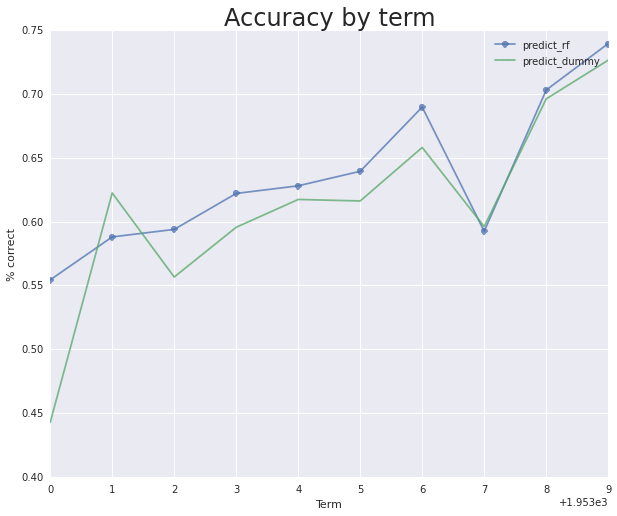

In [47]:
# Get accuracy over time
output_data.loc[output_evaluation_index, "correct"] = (output_data.loc[output_evaluation_index, "justice_outcome_disposition"].fillna(-1) == output_data.loc[output_evaluation_index, "prediction"].fillna(-1)).apply(int)
dummy_data.loc[dummy_evaluation_index, "correct"] = (dummy_data.loc[dummy_evaluation_index, "justice_outcome_disposition"].fillna(-1) == dummy_data.loc[dummy_evaluation_index, "prediction"].fillna(-1)).apply(int)
base_accuracy_by_year = output_data.groupby("term")["correct"].mean()
dummy_accuracy_by_year = dummy_data.groupby("term")["correct"].mean()

# Plot all accuracies
f = plt.figure(figsize=(10, 8))
plt.plot(base_accuracy_by_year.index, base_accuracy_by_year,
         marker='o', alpha=0.75)
plt.plot(dummy_accuracy_by_year.index, dummy_accuracy_by_year,
         marker='x', alpha=0.75)

# Plot
plt.title("Accuracy by term", size=24)
plt.xlabel("Term")
plt.ylabel("% correct")
plt.legend(("predict_rf", "predict_dummy"))

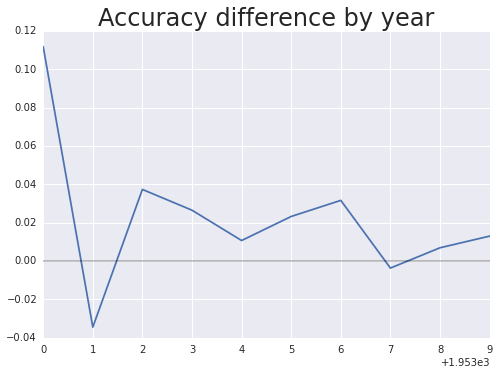

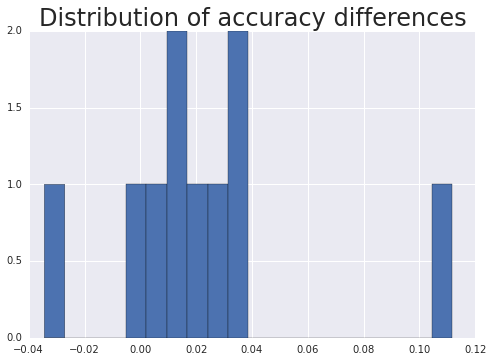

In [48]:
# Plot the spread
spread_by_year = base_accuracy_by_year - dummy_accuracy_by_year
f = plt.figure()
plt.plot(spread_by_year.index, spread_by_year)
p = plt.axhline(color='black', alpha=0.25)
plt.title("Accuracy difference by year", size=24)

# Plot histogram
f = plt.figure()
spread_by_year.hist(bins=20)
plt.title("Distribution of accuracy differences", size=24)

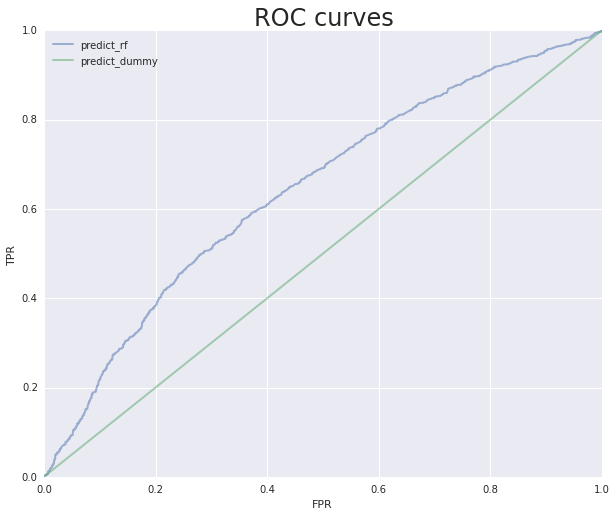

In [49]:
# ROC comparing model FPR/TPRs

# Calculate curves
model_fpr, model_tpr, _ = sklearn.metrics.roc_curve(map(int, output_data["justice_outcome_disposition"].values),
                   output_data["prediction_score"], pos_label=1)

dummy_fpr, dummy_tpr, _ = sklearn.metrics.roc_curve(map(int, dummy_data["justice_outcome_disposition"].values),
                   dummy_data["prediction_score"], pos_label=1)
# Plot curves
f = plt.figure(figsize=(10, 8))
plt.plot(model_fpr, model_tpr, alpha=0.5, linewidth=2)
plt.plot(dummy_fpr, dummy_tpr, alpha=0.5, linewidth=2)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curves", size=24)
plt.legend(("predict_rf", "predict_dummy"),
           loc='best')

(1.8792082280931963, 0.092923651341709462)
(0.30237157840738177, 0.76236881846983984)


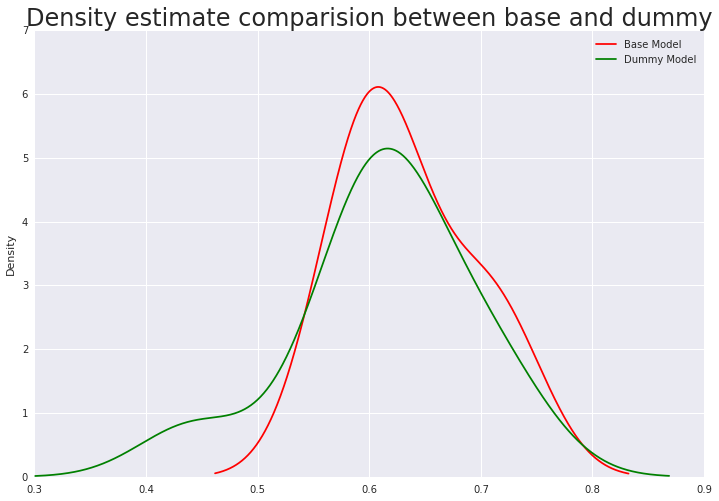

In [50]:
# Plot kernel
f = plt.figure()
p = base_accuracy_by_year.plot(kind='density', figsize=(12,8), legend='auto', color='red')
p = dummy_accuracy_by_year.plot(kind='density', figsize=(12,8), legend='auto', color='green')
plt.legend(('Base Model', 'Dummy Model'), loc='best')
plt.title('Density estimate comparision between base and dummy', size=24)

# Output stats
print(scipy.stats.ttest_rel(base_accuracy_by_year.values,
                   dummy_accuracy_by_year.values))

print(scipy.stats.ranksums(base_accuracy_by_year.values,
                   dummy_accuracy_by_year.values))

## Case outcome assessment

In [51]:
# Initialize
output_data.loc[:, "case_prediction"] = numpy.nan

# Get the case outcomes
for docket_id, docket_data in output_data.groupby('docketId'):
    # Get the most common outcome
    
    # Count predictions from docket
    counts = docket_data["prediction"].value_counts()
    if 0 in counts.index:
        count_0 = counts.ix[0]
    else:
        count_0 = 0
    
    if 1 in counts.index:
        count_1 = counts.ix[1]
    else:
        count_1 = 0
        
    output_data.loc[output_data["docketId"].isin([docket_id]), "case_prediction_score"] = float(count_1) / (count_0 + count_1)
    output_data.loc[output_data["docketId"].isin([docket_id]), "case_prediction"] = counts.idxmax()

# Get the case outcomes
for docket_id, docket_data in dummy_data.groupby('docketId'):
    # Count predictions from docket
    counts = docket_data["prediction"].value_counts()
    if 0 in counts.index:
        count_0 = counts.ix[0]
    else:
        count_0 = 0
    
    if 1 in counts.index:
        count_1 = counts.ix[1]
    else:
        count_1 = 0
        
    dummy_data.loc[output_data["docketId"].isin([docket_id]), "case_prediction_score"] = float(count_1) / (count_0 + count_1)
    dummy_data.loc[output_data["docketId"].isin([docket_id]), "case_prediction"] = counts.idxmax()
    
print(output_data.loc[:, "case_prediction"].value_counts())
print(dummy_data.loc[:, "case_prediction"].value_counts())

1    7379
0    2742
dtype: int64
1    10121
dtype: int64


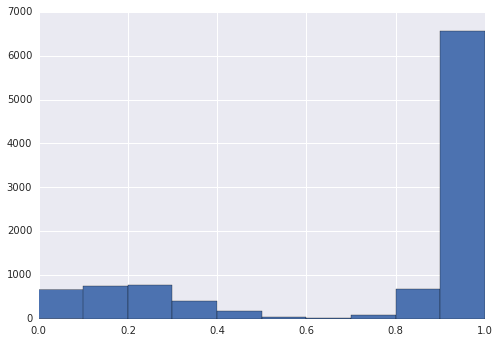

In [52]:
# Distribution of case votes
output_data["case_prediction_score"].hist(bins=10)

In [53]:
output_data["case_prediction"] = (output_data["case_prediction_score"] >= 0.44).apply(int)

# Analyze results
print("predict_rf")
output_evaluation_index = (output_data["case_outcome_disposition"] >= 0)
print(sklearn.metrics.classification_report(output_data.loc[output_evaluation_index, "case_outcome_disposition"].fillna(-1),
                                      output_data.loc[output_evaluation_index, "case_prediction"].fillna(-1)))
print(sklearn.metrics.confusion_matrix(output_data.loc[output_evaluation_index, "case_outcome_disposition"].fillna(-1),
                                      output_data.loc[output_evaluation_index, "case_prediction"].fillna(-1)))
print(sklearn.metrics.accuracy_score(output_data.loc[output_evaluation_index, "case_outcome_disposition"].fillna(-1),
                                      output_data.loc[output_evaluation_index, "case_prediction"].fillna(-1)))
print(sklearn.metrics.f1_score(output_data.loc[output_evaluation_index, "case_outcome_disposition"].fillna(-1),
                                      output_data.loc[output_evaluation_index, "case_prediction"].fillna(-1)))
print("="*32)
print("predict_dummy")
dummy_evaluation_index = (dummy_data["case_outcome_disposition"] >= 0)
print(sklearn.metrics.classification_report(dummy_data.loc[dummy_evaluation_index, "case_outcome_disposition"].fillna(-1),
                                      dummy_data.loc[dummy_evaluation_index, "case_prediction"].fillna(-1)))
print(sklearn.metrics.confusion_matrix(dummy_data.loc[dummy_evaluation_index, "case_outcome_disposition"].fillna(-1),
                                      dummy_data.loc[dummy_evaluation_index, "case_prediction"].fillna(-1)))
print(sklearn.metrics.accuracy_score(dummy_data.loc[dummy_evaluation_index, "case_outcome_disposition"].fillna(-1),
                                      dummy_data.loc[dummy_evaluation_index, "case_prediction"].fillna(-1)))
print(sklearn.metrics.f1_score(dummy_data.loc[dummy_evaluation_index, "case_outcome_disposition"].fillna(-1),
                                      dummy_data.loc[dummy_evaluation_index, "case_prediction"].fillna(-1)))

# Get accuracy over time
output_data.loc[:, "case_correct"] = (output_data["case_outcome_disposition"].fillna(-1) == output_data["case_prediction"].fillna(-1))
dummy_data.loc[:, "case_correct"] = (dummy_data["case_outcome_disposition"].fillna(-1) == dummy_data["case_prediction"].fillna(-1))
base_case_accuracy_by_year = output_data.groupby("term")["case_correct"].mean()
dummy_case_accuracy_by_year = dummy_data.groupby("term")["case_correct"].mean()

predict_rf
             precision    recall  f1-score   support

        0.0       0.53      0.39      0.45      3486
        1.0       0.72      0.82      0.76      6635

avg / total       0.65      0.67      0.66     10121

[[1361 2125]
 [1219 5416]]
0.669597865824
0.764108352144
predict_dummy
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00      3486
        1.0       0.66      1.00      0.79      6635

avg / total       0.43      0.66      0.52     10121

[[   0 3486]
 [   0 6635]]
0.655567631657
0.791955120554


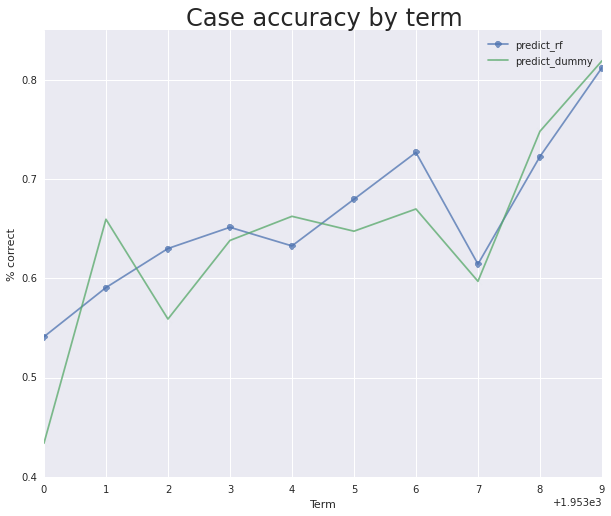

In [59]:
# Plot all accuracies
f = plt.figure(figsize=(10, 8))
plt.plot(base_case_accuracy_by_year.index, base_case_accuracy_by_year,
         marker='o', alpha=0.75)
plt.plot(dummy_case_accuracy_by_year.index, dummy_case_accuracy_by_year,
         marker='x', alpha=0.75)

plt.title("Case accuracy by term", size=24)
plt.xlabel("Term")
plt.ylabel("% correct")
plt.legend(("predict_rf", "predict_dummy"))

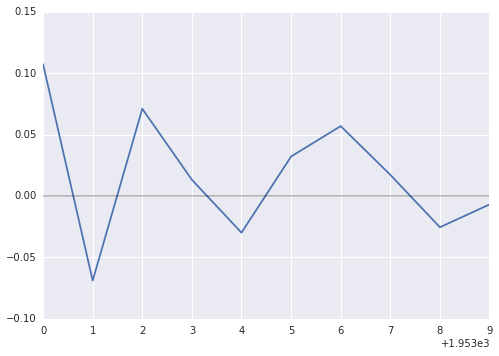

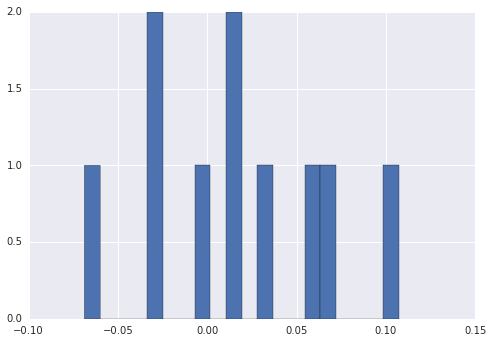

In [55]:
spread_case_by_year = base_case_accuracy_by_year - dummy_case_accuracy_by_year
f = plt.figure()
plt.plot(spread_case_by_year.index, spread_case_by_year)
p = plt.axhline(color='black', alpha=0.25)
f = plt.figure()
spread_case_by_year.hist(bins=20)

(-0.45602723289751607, 0.65917470376431231)
(-0.68033605141660902, 0.49629170223109287)


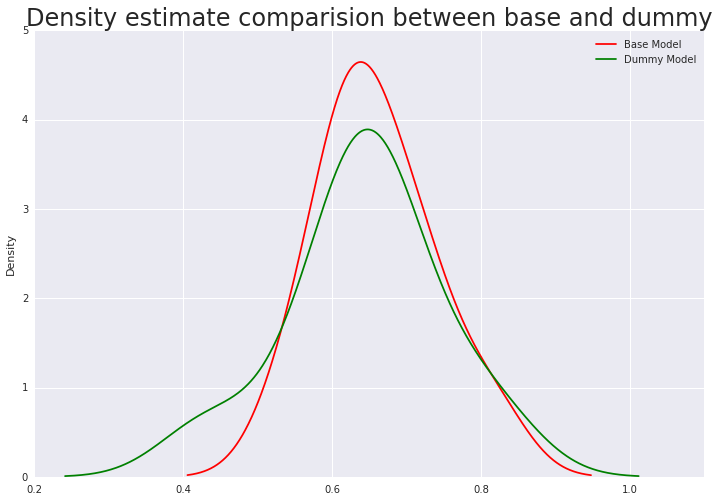

In [58]:
# Plot kernel
f = plt.figure()
p = base_case_accuracy_by_year.plot(kind='density', figsize=(12,8), legend='auto', color='red')
p = dummy_case_accuracy_by_year.plot(kind='density', figsize=(12,8), legend='auto', color='green')
plt.legend(('Base Model', 'Dummy Model'), loc='best')
plt.title('Density estimate comparision between base and dummy', size=24)

# Output stats
print(scipy.stats.ttest_rel(base_accuracy_by_year.values,
                   dummy_case_accuracy_by_year.values))

print(scipy.stats.ranksums(base_accuracy_by_year.values,
                   dummy_case_accuracy_by_year.values))

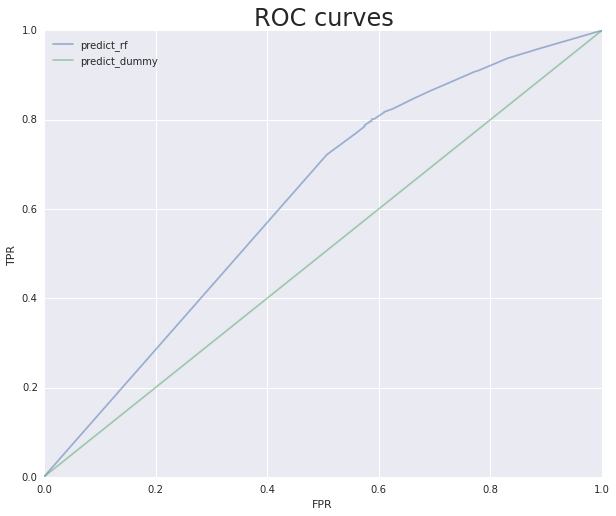

In [60]:
model_fpr, model_tpr, _ = sklearn.metrics.roc_curve(map(int, output_data["case_outcome_disposition"].fillna(0).values),
                   output_data["case_prediction_score"].fillna(0), pos_label=1)

dummy_fpr, dummy_tpr, _ = sklearn.metrics.roc_curve(map(int, dummy_data["case_outcome_disposition"].fillna(0).values),
                   dummy_data["case_prediction_score"].fillna(0), pos_label=1)

f = plt.figure(figsize=(10, 8))
plt.plot(model_fpr, model_tpr, alpha=0.5)
plt.plot(dummy_fpr, dummy_tpr, alpha=0.5)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curves", size=24)
plt.legend(("predict_rf", "predict_dummy"),
           loc='best')

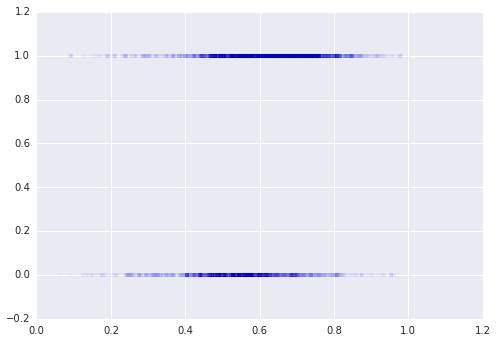

In [57]:
import scipy.stats
f = plt.figure()
plt.scatter(output_data["prediction_score"], output_data["justice_outcome_disposition"],
           alpha=0.01)